# Image reconstruction with Partial Fourier

In this tutoral we will read in a 2D cine dataset from ocmr  (2D+time).
This data is a Cartesian bSSFP cine which has been aquired with Partial Fourier acqustion in the kx (readout) direction (aka readout asymmetry).
We will reconstruct using TensorFlowMRI

## Set up TensorFlow MRI
If you have not yet installed TensorFlow MRI in your environment, you may do so
now using `pip`: 

In [1]:
%pip install --quiet tensorflow-mri
# Upgrade Matplotlib. Versions older than 3.5.x may cause an error below.
%pip install --quiet --upgrade matplotlib


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Then, import the package into your program to get started:

In [2]:
import tensorflow_mri as tfmri
print("TensorFlow MRI version:", tfmri.__version__)

2025-01-18 01:21:02.785946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-18 01:21:02.881833: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-18 01:21:02.908164: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow MRI version: 0.22.0


We will also need a few additional packages:

In [3]:
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

%pip  install -U matplotlib
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.8/dist-packages (3.7.5)
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Using a GPU

TensorFlow MRI supports CPU and GPU computation. If there is a GPU available in
your environment and it is visible to TensorFlow, it will be used automatically.

:::{tip}
In Google Colab, you can enable GPU computation by clicking on
**Runtime > Change runtime type** and selecting **GPU** under
**Hardware accelerator**.
:::

:::{tip}
You can control whether CPU or GPU is used for a particular operation via
the [`tf.device`](https://www.tensorflow.org/api_docs/python/tf/device)
context manager.
:::

## Prepare the data
We will be using an example cardiac cine dataset from the
[ISMRM Reproducibility Challenge 1](https://ismrm.github.io/rrsg/challenge_one/).
Let's download it.

In [4]:
cardiac_cine_data_filename = 'fs_0005_1_5T.h5'
cardiac_cine_data_url = "https://ocmr.s3.us-east-2.amazonaws.com/data/fs_0005_1_5T.h5."
!wget --quiet -O {cardiac_cine_data_filename} {cardiac_cine_data_url}

/bin/bash: wget: command not found


You may need to install 'ismrmrd-python' and 'ismrmrd-python-tools'. This can be done like this:

Install ismrmrd-python from here: https://github.com/ismrmrd/ismrmrd-python

    %%bash
    if [ $(pip list --disable-pip-version-check | grep -c -w 'ismrmrd ') == 0 ]
    then
        git clone https://github.com/ismrmrd/ismrmrd-python.git /var/tmp/ismrmrd-python
        python -m pip install --disable-pip-version-check -r /var/tmp/ismrmrd-python/requirements.txt
        python -m pip install --disable-pip-version-check /var/tmp/ismrmrd-python
        rm -rf /var/tmp/ismrmrd-python
    fi
    pip list --disable-pip-version-check | grep -w 'ismrmrd '

Install ocmr reader from here: https://raw.githubusercontent.com/MRIOSU/OCMR/master/Python/read_ocmr.py

    %%bash
    wget https://raw.githubusercontent.com/MRIOSU/OCMR/master/Python/read_ocmr.py

This dataset contains a fully sampled cartesian dataset. from the OCMR dataset:
https://github.com/MRIOSU/OCMR/blob/master/Python/example_ocmr.ipynb
The data is stored
in a HDF5 file, which we can read using [h5py](https://www.h5py.org/). The
downloaded file also has the sampling locations or *k*-space trajectory, so we
do not need to calculate it.

In [5]:
import read_ocmr as read

kData,param = read.read_ocmr(cardiac_cine_data_filename)
print('Dimension of kData: ', kData.shape)

kData = np.squeeze(kData)
print('Dimension of kData: ', kData.shape)
# kx, ky, ch, phase

# Reverse the order of the dimensions.
# [kx, ky, ch, phase] -> [phase, ch, kx, ky ]
kspace = np.transpose(kData, [3,2,0,1])
print(kspace.shape)
#(18, 18, 512, 208)
#[phase, ch, kx, ky ]


Imaging acquisition starts acq  0
Dimension of kData:  (512, 208, 1, 18, 18, 1, 1, 1, 1)
Dimension of kData:  (512, 208, 18, 18)
(18, 18, 512, 208)


Lets view the k-space data

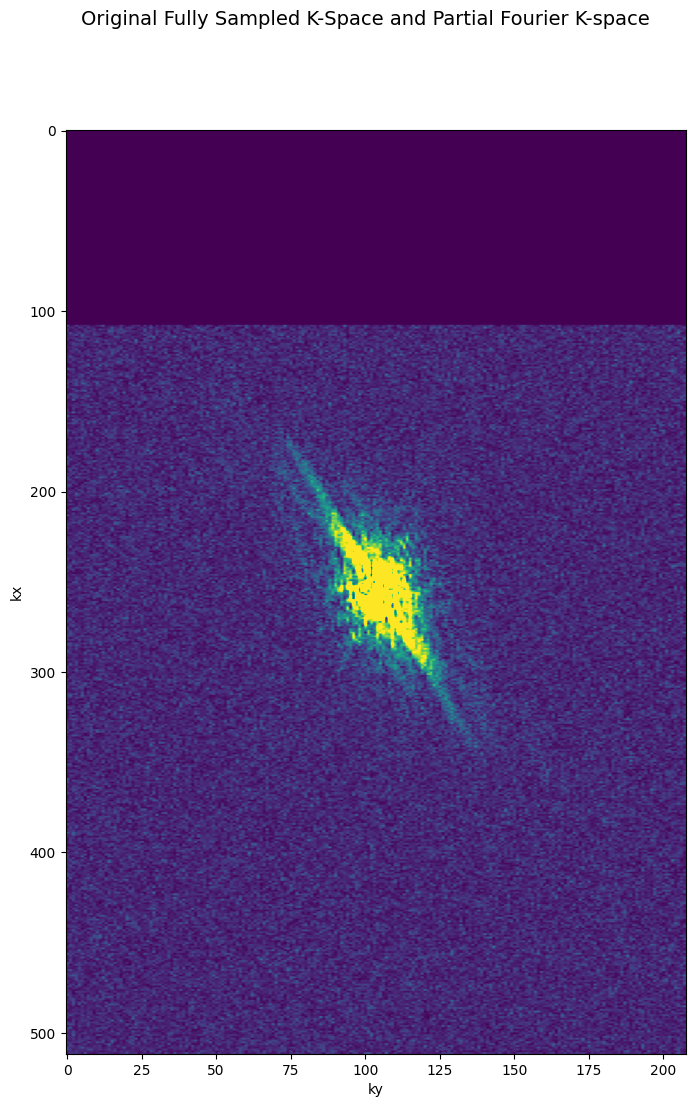

In [6]:
fig1 = plt.figure(1, figsize=(8, 12)); fig1.suptitle("Original Fully Sampled K-Space and Partial Fourier K-space", fontsize=14);
tmp = plt.imshow(np.abs(np.squeeze(kspace[0,0,:,:])), aspect= 'auto')
plt.xlabel('ky');plt.ylabel('kx'); tmp.set_clim(0.0,0.01*np.max(np.abs(kspace))) # ky by kx

You can see that this k-space was acquired with Partial Foutier in the readout, kx, direction (only 404 of the 512 data points are acquired)

(18, 18, 404, 208)
0.7890625


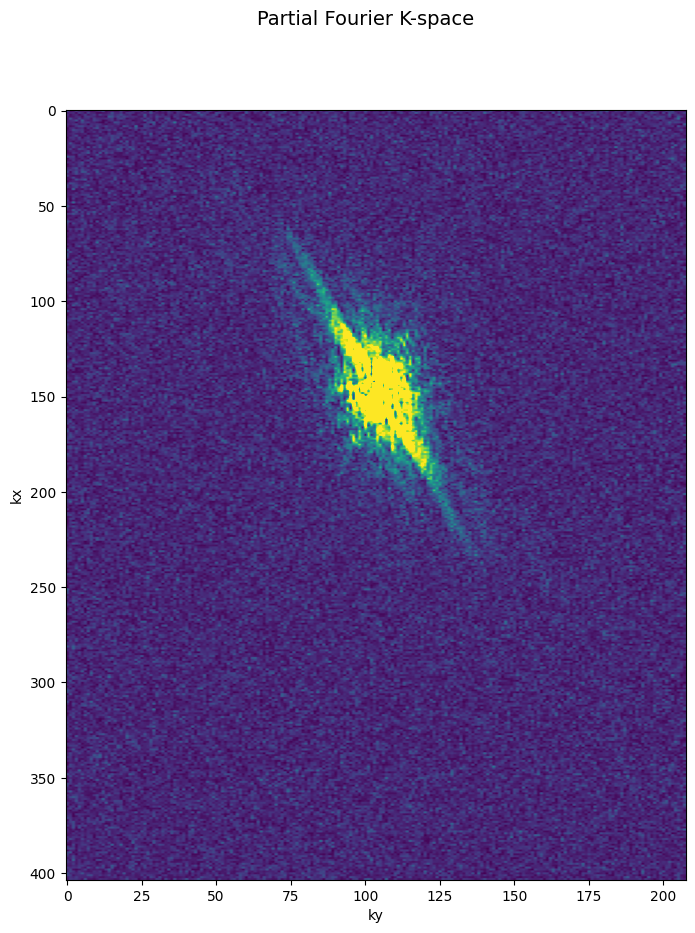

In [7]:
# The tensorflow functions for Partial Fourier Reconstruction takes in only the k-space which was acquired
# kspace should only contain the observed data, without zero-filling of any kind.

# Therefore iin this case we need to remove all phase encode lines which are all zeros

# Find rows that contain only zeros
kspace_PF = kspace[:, :, np.any(kspace != 0, axis=(0, 1, 3)),:]
print(kspace_PF.shape)
# (18, 18, 404, 208)

# The tensowflow function needs to know what proportion if k-space was acquired
partial_fourier_factor = kspace_PF.shape[2] / kspace.shape[2]
print(partial_fourier_factor)
# 0.7890625

# Now plot the k-sopace without the zero lines to check that we have got only the acquired data
fig1 = plt.figure(1, figsize=(8, 10)); fig1.suptitle("Partial Fourier K-space", fontsize=14)
tmp = plt.imshow(np.abs(np.squeeze(kspace_PF[0,0,:,:])), aspect= 'auto')
plt.xlabel('ky');plt.ylabel('kx'); tmp.set_clim(0.0,0.01*np.max(np.abs(kspace))) # ky by kx

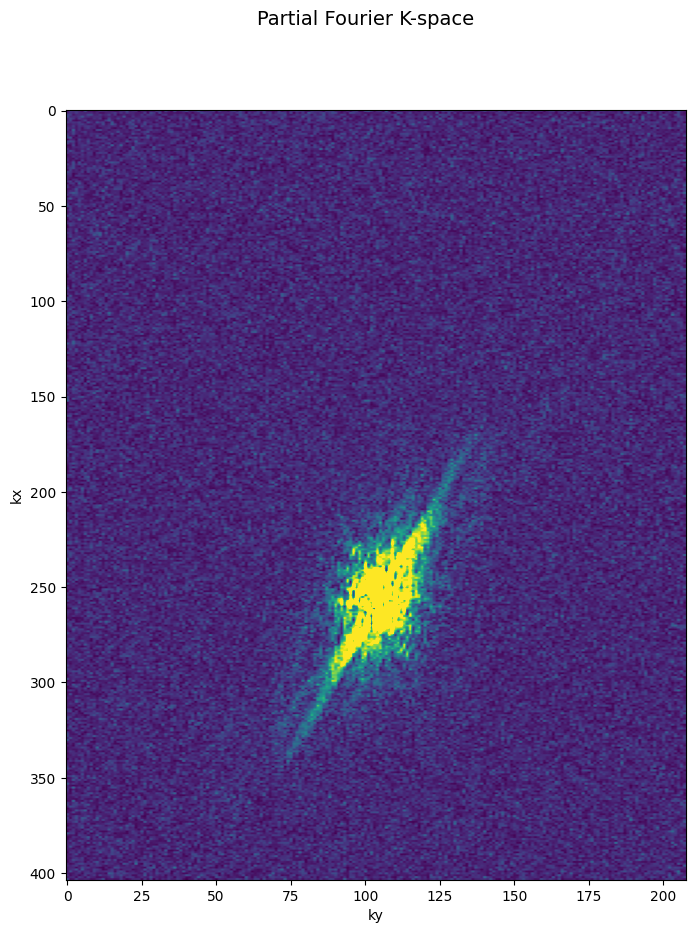

In [8]:
# First we need to flip the array so that the 'missing' part of k-space is at the end...

kspace_PF_flipped = np.flip(kspace_PF, axis=-2)

# Now plot the k-sopace without the zero lines to check that we have got only the acquired data
fig1 = plt.figure(1, figsize=(8, 10)); fig1.suptitle("Partial Fourier K-space", fontsize=14)
tmp = plt.imshow(np.abs(np.squeeze(kspace_PF_flipped[0,0,:,:])), aspect= 'auto')
plt.xlabel('ky');plt.ylabel('kx'); tmp.set_clim(0.0,0.01*np.max(np.abs(kspace_PF_flipped))) # ky by kx

In [9]:
# Now do a partial fourier reconstruction seperately each time point seperately
# tfmri can do all time point together but it is less likey to run out of memory if we process one time point at a time

Reconstructed_Image = []
for t in range(np.shape(kspace_PF_flipped)[0]):

    kspace_PF_single_phase = np.squeeze(kspace_PF_flipped[t,:,:,:])
    #[ch, kx, ky ]
    #print(kspace_PF_single_phase.shape)
    #(18, 512, 124)

    recon_im = tfmri.recon.partial_fourier(
            kspace_PF_single_phase, [partial_fourier_factor, 1.0], method="pocs",
            preserve_phase=True)
    #print(kspace_PF_single_phase.shape)
    #(18, 512, 207)
    #[ch, x, y ]

    recon_im = np.flip(recon_im, axis=-2)
    # method can be "zerofill", "homodyne" (homodyne detection method) or "pocs" (projection onto convex sets method).
    Reconstructed_Image.append(recon_im)

final_cine = np.array(Reconstructed_Image)

2025-01-18 01:21:26.217422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-18 01:21:27.147565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22158 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2025-01-18 01:21:27.149021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22173 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6


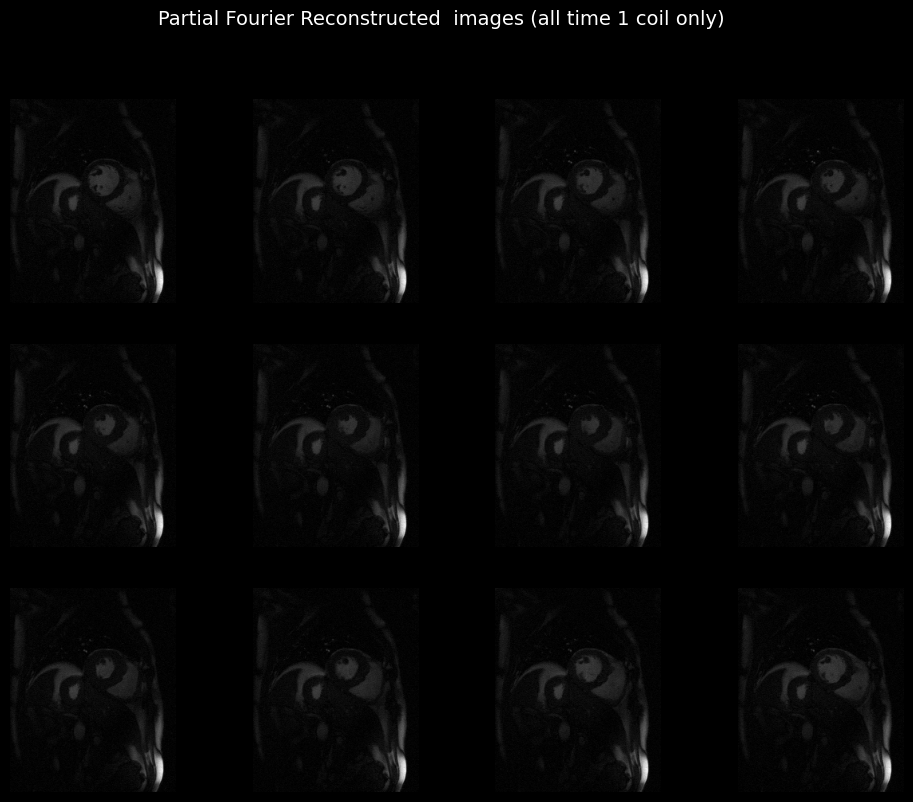

In [10]:
def plot_tiled_images(image):
  _, axs = plt.subplots(3, 4, facecolor='k', figsize=(12, 9))

  artists = []
  for index in range(12):
    col, row = index // 4, index % 4
    artists.append(
        axs[col, row].imshow(image[index, ...], cmap='gray')
    )
    axs[col, row].axis('off')
  return artists

#remove RO oversampling
ROsize = final_cine.shape[2]

final_cine = final_cine[:,:,int(ROsize/4):int(3*ROsize/4),:]
 #[ph,ch, x, y ]
 #(18, 18, 256, 208)

_ = plot_tiled_images(np.squeeze(tf.math.abs(final_cine[:,2,:,:])))
_ = plt.gcf().suptitle('Single Coil Partial Fourier Reconstructed  images (all time 1 coil only)',
                       color='w', fontsize=14)

(18, 256, 208)


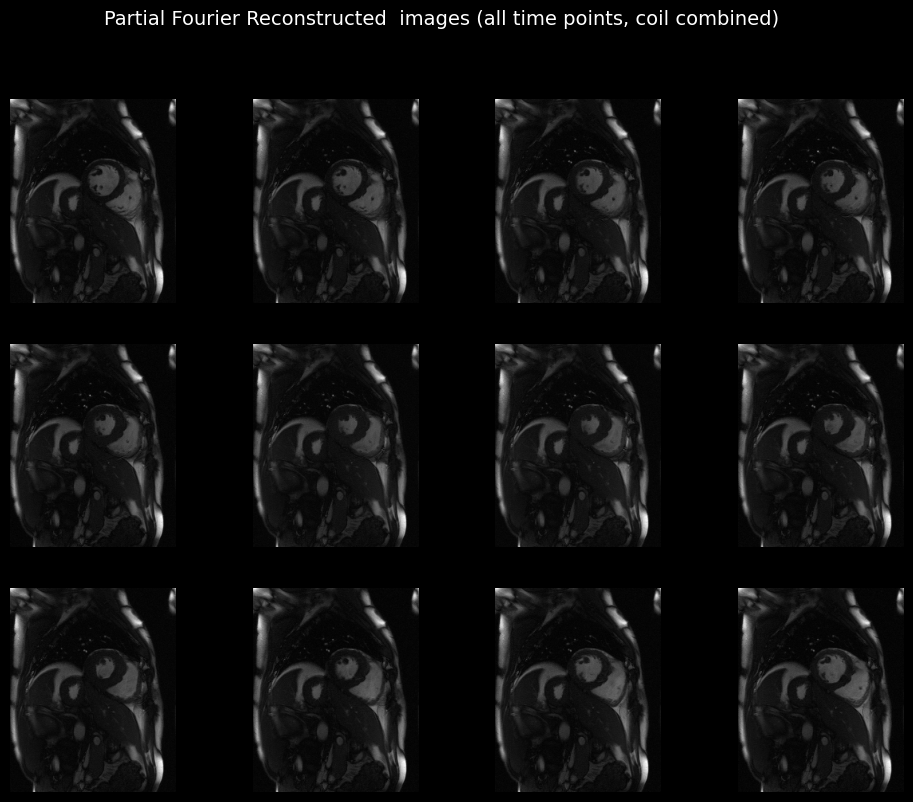

In [11]:
# now do coil combination
coil_combined_cine = tfmri.coils.combine_coils(final_cine, maps=None, coil_axis= 1)
print(coil_combined_cine.shape)
# 18, 256, 256

_ = plot_tiled_images(np.squeeze(tf.math.abs(coil_combined_cine)))
_ = plt.gcf().suptitle('Coil Combined Partial Fourier Reconstructed  images (all time points)',
                       color='w', fontsize=14)

In [12]:
import matplotlib.animation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

nFrames = len(Reconstructed_Image)

t= np.linspace(0,len(Reconstructed_Image))
def animate(t):
    plt.imshow(np.squeeze(tf.math.abs(coil_combined_cine[t,:,:])), cmap = 'gray')
    plt.title('Image')

matplotlib.animation.FuncAnimation(fig, animate, frames=nFrames)

## Conclusion
Congratulations! You performed a partial Fourier reconstruction using
TensorFlow MRI. The code used in this notebook works for any amount of partial Fourier.
 It also works for 3D imaging. Feel free to try with your own data!

For more information about the functions used in this tutorial, check out the
[API documentation](https://mrphys.github.io/tensorflow-mri/api_docs/). For
more examples of using TensorFlow MRI, check out the
[tutorials](https://mrphys.github.io/tensorflow-mri/tutorials/).

### Let us know!
Please tell us what you think about this tutorial and about TensorFlow MRI.
We would like to hear what you liked and how we can improve. You will find us
on [GitHub](https://github.com/mrphys/tensorflow-mri/issues/new).

In [13]:
# Copyright 2022 University College London. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.